# Final Validation of the selected model

Here the final validation and visualization of the selected model is performed.

### Importing the standard libraries

In [119]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the dataset

In [120]:
dataset = pd.read_csv('../assets/car-details-for-ml.csv')

dataset.head()

,year,km_driven,fuel,transmission,seller_type,owner,seats,mileage,engine,max_power,...,Mitsubishi,Nissan,Opel,Renault,Skoda,Tata,Toyota,Volkswagen,Volvo,selling_price
0,2014,145500,0,0,1,0,5.0,23.40,1248,74.00,...,0,0,0,0,0,0,0,0,0,450000
1,2014,120000,0,0,1,2,5.0,21.14,1498,103.52,...,0,0,0,0,1,0,0,0,0,370000
2,2006,140000,1,0,1,3,5.0,17.70,1497,78.00,...,0,0,0,0,0,0,0,0,0,158000
3,2010,127000,0,0,1,0,5.0,23.00,1396,90.00,...,0,0,0,0,0,0,0,0,0,225000
4,2007,120000,1,0,1,0,5.0,16.10,1298,88.20,...,0,0,0,0,0,0,0,0,0,130000


### Splitting the dataset into the Training and Test set

In [121]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=73)

### Helper methods for the model

In [123]:
# Plots n predictions and actual values against each other
import random

def plot_results_graph(model: str, y_test, y_pred, start: int = 0, end: int = 200):
    color = (random.random(), random.random(), 0)

    plt.figure(figsize=(20, 8))
    plt.plot(y_test[start:end], color="b")
    plt.plot(y_pred[start:end], '--', color=color,)
    plt.title(model)
    plt.ylabel('Price')
    plt.legend(['Actual value','Predicted value'])
    plt.show()

In [124]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# R2 (R-squared) score = Statistical measure of how close the predicted data are to the actual data.
# Mean Absolute Error (MAE) = The mean value of all errors, positive and negative (absolute value)
# Root Mean Squared Error (RMSE) = The errors are squared and then the mean value is found. The root of the calculated mean value is taken.

labels = ['Model', 'R2', 'MAE', 'RMSE']
results = []

def model_evaluation(model: str, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    results.append([model, r2, mae, rmse])
    return [model, r2, mae, rmse]

# The Random Forest Model

The Random Forest Model performed the best in the model selection process. This model is used for the final validation.

In [125]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=73)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=73)

In [126]:
y_pred = forest_reg.predict(X_test)

np.set_printoptions(precision=2)
actual_vs_pred = np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1)

print(["Actual", "Predictions"])
print(actual_vs_pred[:8])

['Actual', 'Predictions']
[[3400000.   3523600.  ]
 [ 950000.   1078759.99]
 [ 934000.    776176.18]
 [ 450000.    438850.  ]
 [ 350000.    428389.98]
 [ 140000.    195979.99]
 [1125000.   1161620.  ]
 [ 316000.    275261.67]]


In [127]:
forest_reg_result = model_evaluation('Random Forest Regression', y_test, y_pred)

for i in range(len(forest_reg_result)):
    print(labels[i], ':', forest_reg_result[i])

Model : Random Forest Regression
R2 : 0.968150075757641
MAE : 62365.82973007254
RMSE : 105968.34395664117


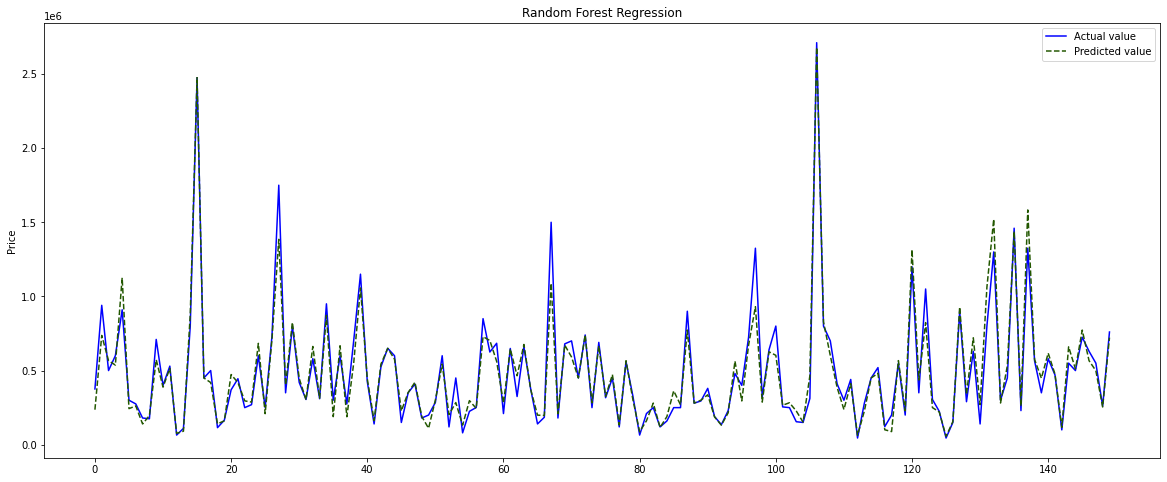

In [128]:
plot_results_graph('Random Forest Regression', y_test, y_pred, 1250, 1400)

### Better validation using Cross Validation

In [129]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_reg, X_train, y_train, cv=10, scoring='r2')

In [130]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.95 0.96 0.96 0.94 0.95 0.94 0.93 0.97 0.97 0.95]
Mean: 0.9516562727645939
Standard Deviation: 0.013775443502744058


Looking at the scores, the model has an very average r2 score across the cross validation, which is great.

### Let's see if we can improve the model using GridSearchCV

In [131]:
from sklearn.model_selection import GridSearchCV

params = [
    { 'n_estimators': [10, 100, 200, 300], 'max_features': [9, 10, 11, 41] }
]

forest_reg = RandomForestRegressor(random_state=73)

grid_search = GridSearchCV(forest_reg, params, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=73),
             param_grid=[{'max_features': [9, 10, 11, 41],
                          'n_estimators': [10, 100, 200, 300]}],
             return_train_score=True, scoring='r2')

In [132]:
print("Best params:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)

Best params: {'max_features': 10, 'n_estimators': 300}
Best estimator: RandomForestRegressor(max_features=10, n_estimators=300, random_state=73)


Quite surprised that the model performs better with fewer features. Let's test this and compare the results.

In [133]:
y_pred = grid_search.predict(X_test)

np.set_printoptions(precision=2)
actual_vs_pred = np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1)

print(["Actual", "Predictions"])
print(actual_vs_pred[:8])

['Actual', 'Predictions']
[[3400000.   3454350.  ]
 [ 950000.   1079787.16]
 [ 934000.    760946.49]
 [ 450000.    425168.33]
 [ 350000.    410566.66]
 [ 140000.    186351.64]
 [1125000.   1090983.05]
 [ 316000.    278579.33]]


In [134]:
grid_search_result = model_evaluation('Random Forest Grid Search', y_test, y_pred)

for i in range(len(grid_search_result)):
    print(labels[i], ':', grid_search_result[i])

Model : Random Forest Grid Search
R2 : 0.9693627238158378
MAE : 60370.86423895373
RMSE : 103931.45836011347


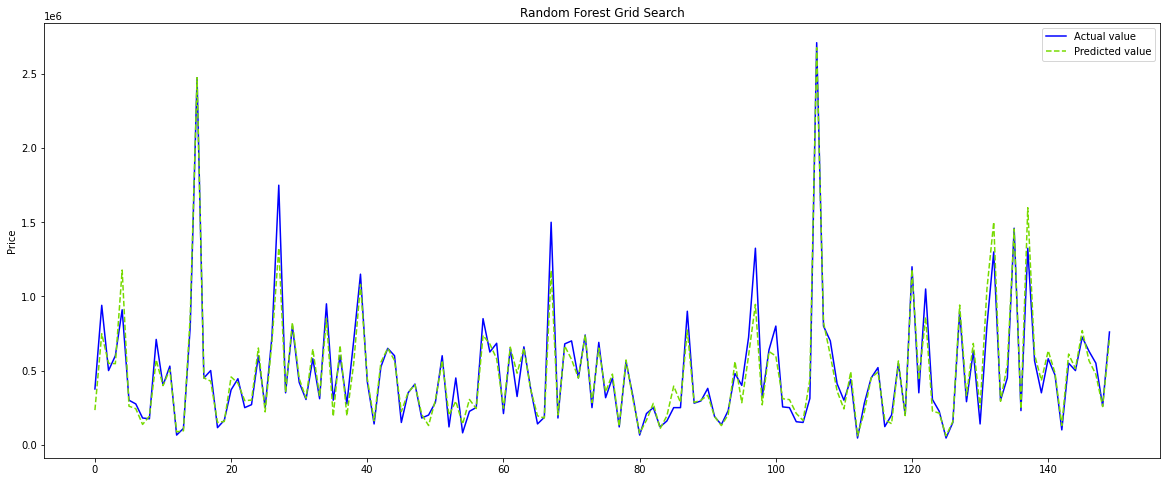

In [135]:
plot_results_graph('Random Forest Grid Search', y_test, y_pred, 1250, 1400)

Surprisingly, the model performs slightly better with fewer features than the Random Forest Model with all features. Let's see if can improve the model further using randomized search.

### Randomized Search

In [136]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distribs = { 
    'n_estimators': randint(low=1, high=300),
    'max_features': randint(low=1, high=12) 
}


forest_reg = RandomForestRegressor(random_state=73)

rnd_search = RandomizedSearchCV(forest_reg, params_distribs, cv=5, scoring='r2', n_iter=10, return_train_score=True, verbose=2, random_state=73)
rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................max_features=7, n_estimators=147; total time=   0.7s
[CV] END ...................max_features=7, n_estimators=147; total time=   0.6s
[CV] END ...................max_features=7, n_estimators=147; total time=   0.6s
[CV] END ...................max_features=7, n_estimators=147; total time=   0.7s
[CV] END ...................max_features=7, n_estimators=147; total time=   0.7s
[CV] END ..................max_features=11, n_estimators=273; total time=   1.6s
[CV] END ..................max_features=11, n_estimators=273; total time=   1.5s
[CV] END ..................max_features=11, n_estimators=273; total time=   1.5s
[CV] END ..................max_features=11, n_estimators=273; total time=   1.6s
[CV] END ..................max_features=11, n_estimators=273; total time=   1.5s
[CV] END ...................max_features=9, n_estimators=167; total time=   0.8s
[CV] END ...................max_features=9, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=73),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D4BF891040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D4ADAAEA60>},
                   random_state=73, return_train_score=True, scoring='r2',
                   verbose=2)

In [137]:
print("Best params:", rnd_search.best_params_)
print("Best estimator:", rnd_search.best_estimator_)

Best params: {'max_features': 7, 'n_estimators': 147}
Best estimator: RandomForestRegressor(max_features=7, n_estimators=147, random_state=73)


In [138]:
y_pred = rnd_search.predict(X_test)

np.set_printoptions(precision=2)
actual_vs_pred = np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1)

print(["Actual", "Predictions"])
print(actual_vs_pred[:8])

['Actual', 'Predictions']
[[3400000.   3377598.63]
 [ 950000.   1073020.29]
 [ 934000.    754191.04]
 [ 450000.    417602.04]
 [ 350000.    409217.68]
 [ 140000.    176197.24]
 [1125000.   1107278.9 ]
 [ 316000.    277574.6 ]]


In [139]:
rnd_search_result = model_evaluation('Random Forest Randomized Search', y_test, y_pred)

for i in range(len(rnd_search_result)):
    print(labels[i], ':', rnd_search_result[i])

Model : Random Forest Randomized Search
R2 : 0.9689344360523776
MAE : 60629.08158328047
RMSE : 104655.38182240623


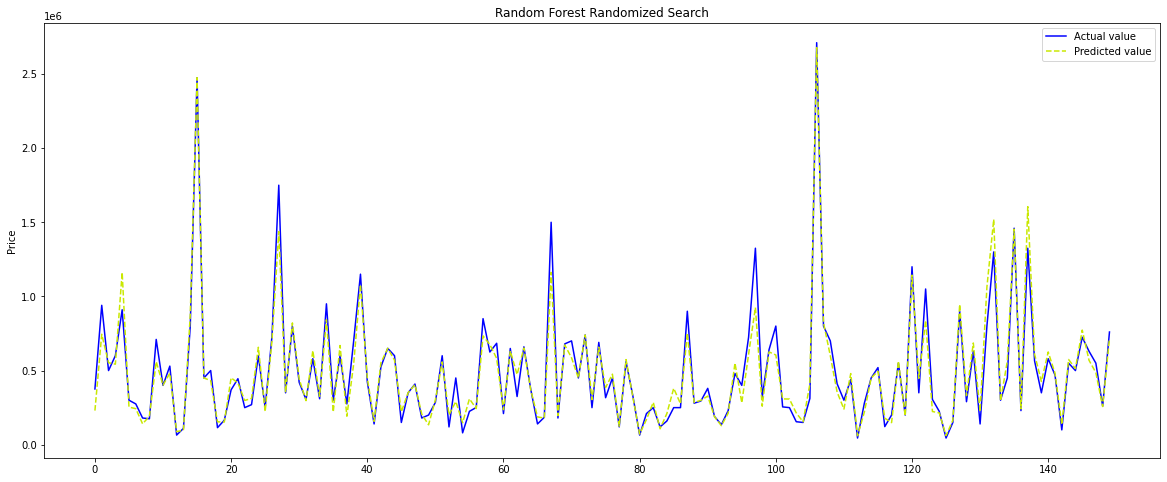

In [140]:
plot_results_graph('Random Forest Randomized Search', y_test, y_pred, 1250, 1400)